# <p align="center">Depression detection in Sinhala-English code-mixed text</p>
------------

## Importing necessary packages

In [1]:
# import the required libraries
import pandas as pd
import numpy as np
import re
import emoji
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB, ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')
import joblib

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Dataset and Pre-processing

In [2]:
#Importing the dataset
data = pd.read_csv('Singlish_data.csv')
data.head()

,text,label
0,nati bari kam aga higa kam mada jeewath wenawa...,1
1,oba samata suba dawasak wewa,0
2,hamadema athaharala giyanam hari wage,1
3,raata dilisena luminious paata tharu tikak kaa...,0
4,mata manasika gataluwak thiyenawa. katha krnna...,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1000 non-null   object
 1   label   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


Getting the stop words list from the text file

In [4]:
NLTK_stop_words_list=stopwords.words('english')

with open("stop_words.txt") as f:
    content_list = f.readlines()

# remove new line characters
stop_words = [x.strip() for x in content_list]
final_stop_words = NLTK_stop_words_list + stop_words
print(final_stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [5]:
#creating a function to pre-process the Singlish text
def data_processing(text):

    # removal of capitalization
    text = text.lower()
    # remove numbers
    text = re.sub(r"\d+", "", str(text))
    # remove url
    text = re.sub(r"https?://\S+|www\.\S+", "", text)
    # remove HTML tags
    text = re.sub(r"<.*?>", "", text)
    # remove emojis
    text = emoji.replace_emoji(text, replace='')
    # remove re-tweets status
    text = re.sub(r'^RT @\w*: ', ' ', text)
    # remove mentions
    text = re.sub(r'@\w*', ' ', text)
    # remove special characters
    text = re.sub(r'[!@#&*$.?,]', ' ', text)
    # remove \n
    text = re.sub(r'\n', ' ', text)
    # remove ''
    text = re.sub("'", '', text)
    
    
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in final_stop_words]
    preprocessed_text = " ".join(filtered_text)
    return preprocessed_text

In [6]:
data_processing('hamadema athaharala giyanam hari wage@#### <font> why')

'hamadema athaharala giyanam hari'

In [7]:
data.text = data['text'].apply(data_processing)

In [8]:
data = data.drop_duplicates('text')

In [9]:
data.head()

,text,label
0,nati bari kam aga higa kam mada jeewath wenawa...,1
1,samata suba dawasak wewa,0
2,hamadema athaharala giyanam hari,1
3,raata dilisena luminious paata tharu tikak kaa...,0
4,manasika gataluwak thiyenawa katha krnna puluw...,1


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 985 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    985 non-null    object
 1   label   985 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 23.1+ KB


In [11]:
data['label'].value_counts()

0    550
1    435
Name: label, dtype: int64

## Data visualization and analysis

<AxesSubplot:xlabel='label', ylabel='count'>

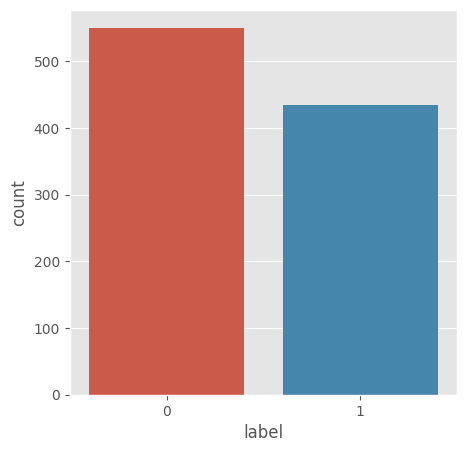

In [12]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x='label', data = data)

Text(0.5, 1.0, 'Distribution of sentiments')

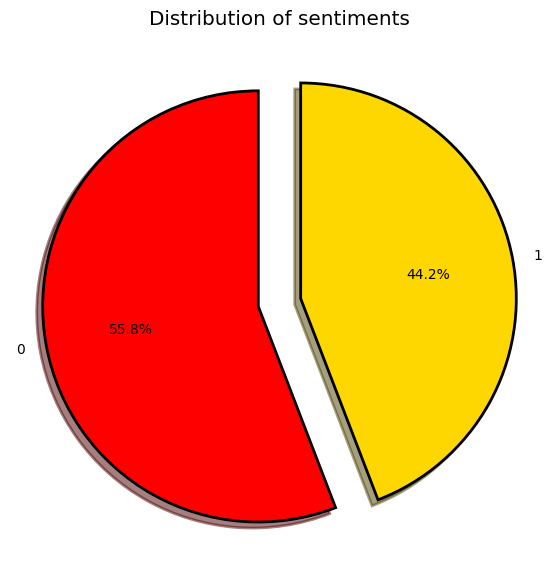

In [13]:
fig = plt.figure(figsize=(7,7))
colors = ("red", "gold")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = data['label'].value_counts()
explode = (0.1, 0.1)
tags.plot(kind='pie',autopct = '%1.1f%%', shadow=True, colors = colors, startangle =90, 
         wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

In [14]:
non_depressed = data[data.label == 0]
non_depressed.head()

,text,label
1,samata suba dawasak wewa,0
3,raata dilisena luminious paata tharu tikak kaa...,0
5,mageth thiyenawa maru ne,0
6,ow kochchara hoda karath dakinne na anith aya ...,0
7,one uthsahaya na nagitinna nagitinna pahalatam...,0


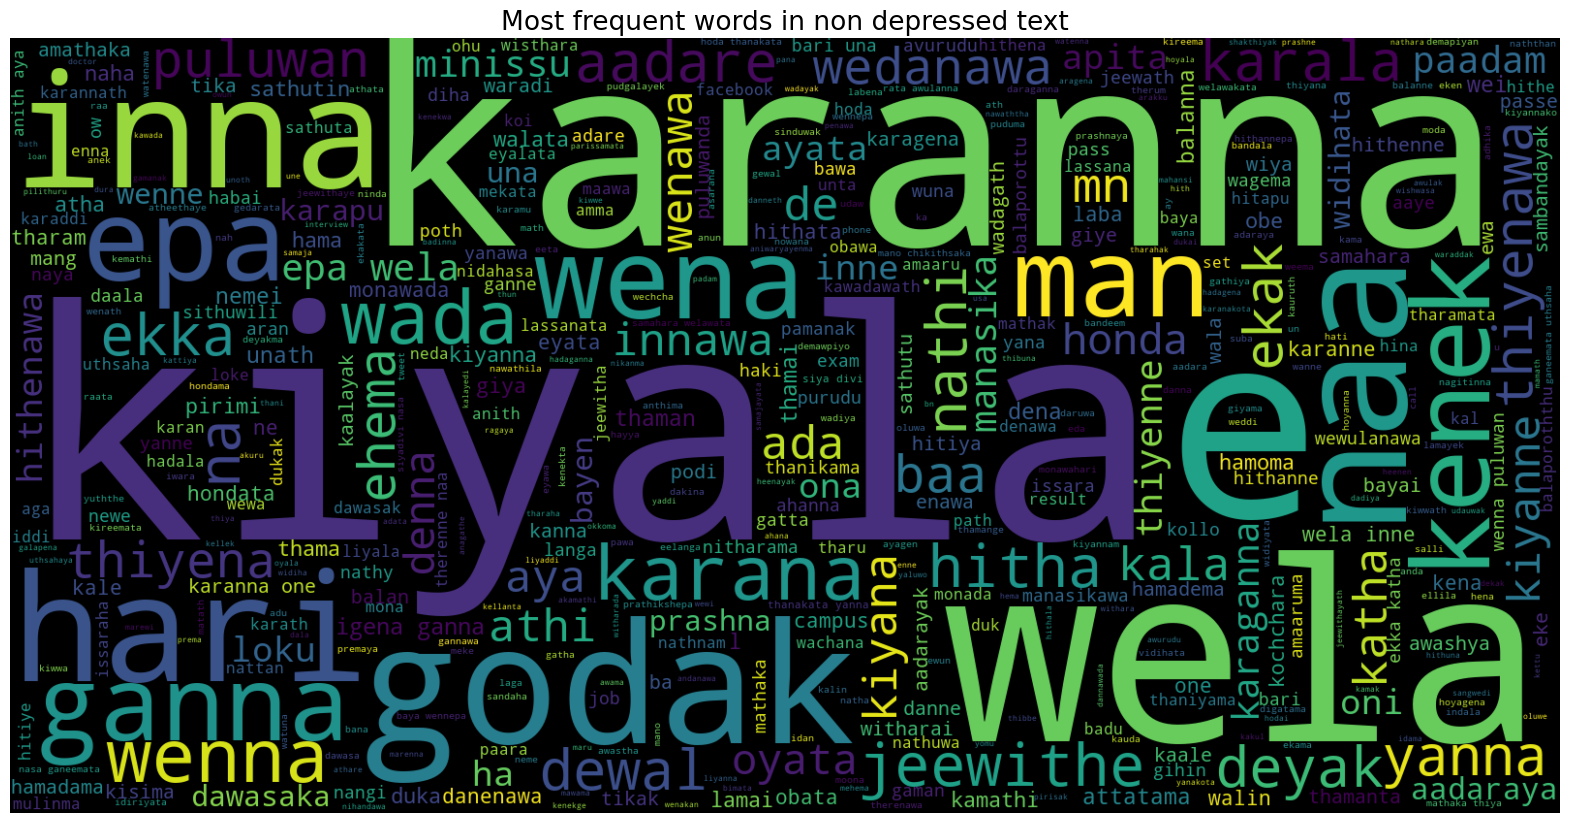

In [15]:
text = ' '.join([word for word in non_depressed['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in non depressed text', fontsize = 19)
plt.show()

In [16]:
depressed = data[data.label == 1]
depressed.head()

,text,label
0,nati bari kam aga higa kam mada jeewath wenawa...,1
2,hamadema athaharala giyanam hari,1
4,manasika gataluwak thiyenawa katha krnna puluw...,1
8,hamawelema kawruth naha thani wela kiyala hith...,1
10,hamotama witharak waradhikaraya wenawa hamadam...,1


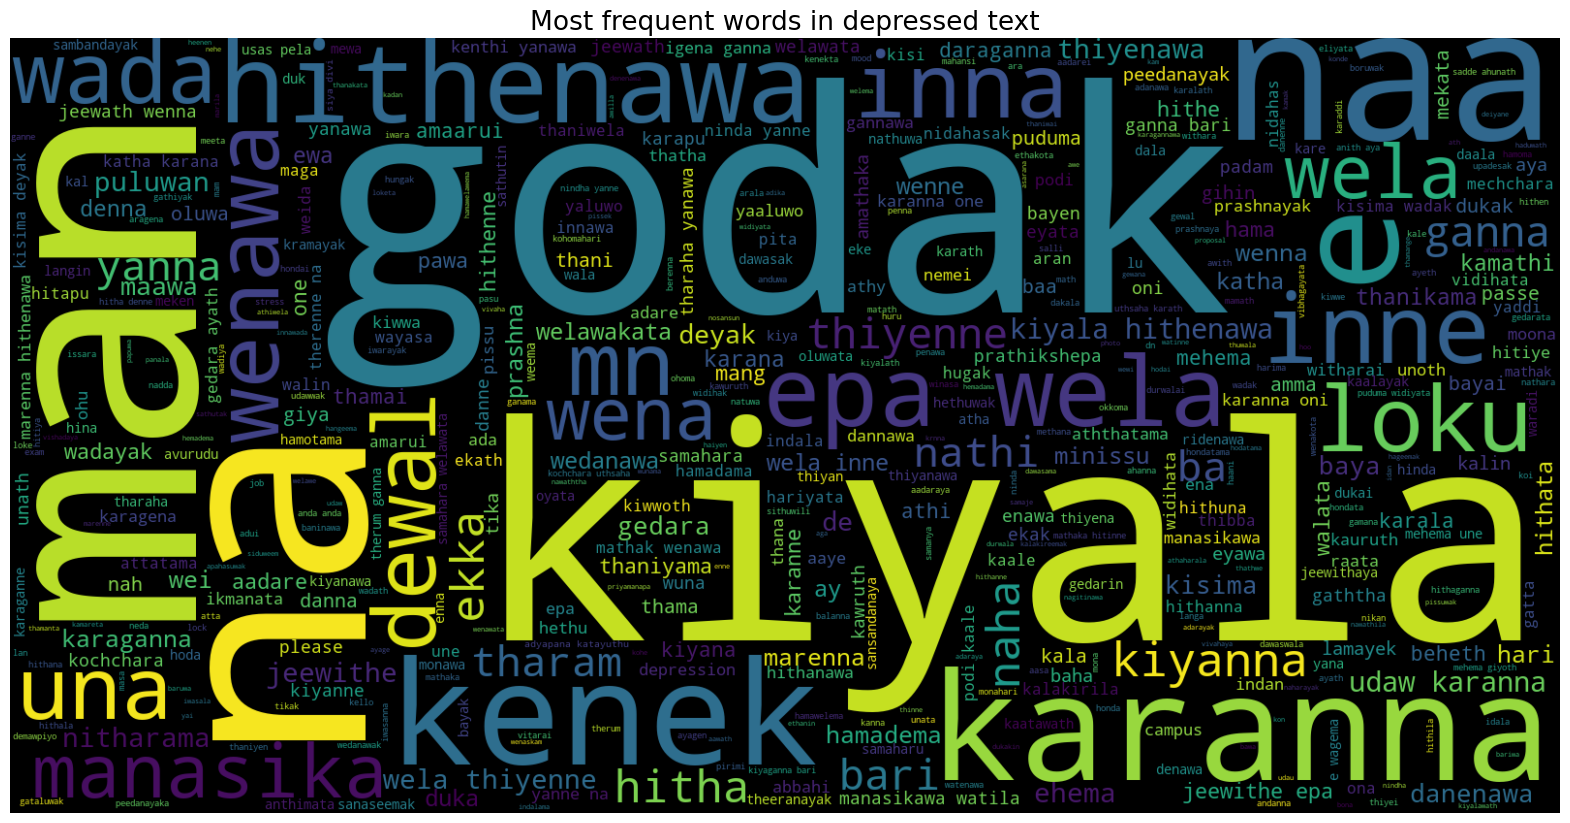

In [17]:
text = ' '.join([word for word in depressed['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in depressed text', fontsize = 19)
plt.show()

## Feature extraction

In [18]:
vect = TfidfVectorizer(ngram_range = (1,5), min_df = 3, analyzer = 'char_wb').fit(data['text'])

In [19]:
feature_names = vect.get_feature_names_out()
print("Number of features: {}\n".format(len(feature_names)))

Number of features: 7276



## Model Building and Training

In [20]:
X = data['text']
Y = data['label']
X = vect.transform(X)

In [21]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [22]:
print("Size of x_train:", (x_train.shape))
print("Size of y_train:", (y_train.shape))
print("Size of x_test: ", (x_test.shape))
print("Size of y_test: ", (y_test.shape))

Size of x_train: (788, 7276)
Size of y_train: (788,)
Size of x_test:  (197, 7276)
Size of y_test:  (197,)


In [25]:
logreg = LogisticRegression(max_iter=10, penalty='l2', random_state=8, solver='liblinear')
logreg.fit(x_train, y_train)
logreg_predict = logreg.predict(x_test)
logreg_acc = accuracy_score(logreg_predict, y_test)
print("Test accuarcy: {:.2f}%".format(logreg_acc*100))

Test accuarcy: 74.11%


In [26]:
print(confusion_matrix(y_test, logreg_predict))
print("\n")
print(classification_report(y_test, logreg_predict))

[[100  15]
 [ 36  46]]


              precision    recall  f1-score   support

           0       0.74      0.87      0.80       115
           1       0.75      0.56      0.64        82

    accuracy                           0.74       197
   macro avg       0.74      0.72      0.72       197
weighted avg       0.74      0.74      0.73       197



In [178]:
param_grid = {'C':[100, 10, 1.0, 0.1, 0.01], 'solver' :['newton-cg', 'lbfgs','liblinear']}
grid = GridSearchCV(LogisticRegression(), param_grid, cv = 5)
grid.fit(x_train, y_train)
print("Best Cross validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best Cross validation score: 0.74
Best parameters:  {'C': 10, 'solver': 'newton-cg'}


In [179]:
y_pred = grid.predict(x_test)
logreg_acc = accuracy_score(y_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

Test accuracy: 71.57%
[[92 23]
 [33 49]]


              precision    recall  f1-score   support

           0       0.74      0.80      0.77       115
           1       0.68      0.60      0.64        82

    accuracy                           0.72       197
   macro avg       0.71      0.70      0.70       197
weighted avg       0.71      0.72      0.71       197



In [176]:
svm = SVC(C=1, kernel='rbf', probability=True)
svm.fit(x_train, y_train)
svm_predict = svm.predict(x_test)
svm_acc = accuracy_score(svm_predict, y_test)

In [177]:
print("Test accuarcy: {:.2f}%".format(svm_acc*100))
print(confusion_matrix(y_test, svm_predict))
print("\n")
print(classification_report(y_test, svm_predict))

Test accuarcy: 72.59%
[[97 18]
 [36 46]]


              precision    recall  f1-score   support

           0       0.73      0.84      0.78       115
           1       0.72      0.56      0.63        82

    accuracy                           0.73       197
   macro avg       0.72      0.70      0.71       197
weighted avg       0.72      0.73      0.72       197



In [174]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000], 
    'gamma': [0.1, 1, 10],
    'kernel': ['rbf', 'poly', 'sigmoid', 'linear'],
    # 'degree': [1, 3, 5, 7, 9]
}

grid = GridSearchCV(SVC(), param_grid, scoring = 'accuracy', cv = 5, n_jobs = -1, refit = True, verbose = 2)
grid.fit(x_train, y_train)
print("Best Cross validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Cross validation score: 0.74
Best parameters:  {'C': 1, 'gamma': 1, 'kernel': 'rbf'}


In [175]:
grid_predictions = grid.predict(x_test)
grid_acc = accuracy_score(grid_predictions, y_test)
print("Test accuarcy: {:.2f}%".format(grid_acc*100))
print(confusion_matrix(y_test, grid_predictions))
print("\n")
print(classification_report(y_test, grid_predictions))

Test accuarcy: 72.59%
[[97 18]
 [36 46]]


              precision    recall  f1-score   support

           0       0.73      0.84      0.78       115
           1       0.72      0.56      0.63        82

    accuracy                           0.73       197
   macro avg       0.72      0.70      0.71       197
weighted avg       0.72      0.73      0.72       197



In [65]:
mnb = MultinomialNB(alpha=0.9)
mnb.fit(x_train, y_train)
mnb_predict = mnb.predict(x_test)
mnb_acc = accuracy_score(mnb_predict, y_test)

In [66]:
print("Test accuarcy: {:.2f}%".format(mnb_acc*100))
print(confusion_matrix(y_test, mnb_predict))
print("\n")
print(classification_report(y_test, mnb_predict))

Test accuarcy: 73.60%
[[93 22]
 [30 52]]


              precision    recall  f1-score   support

           0       0.76      0.81      0.78       115
           1       0.70      0.63      0.67        82

    accuracy                           0.74       197
   macro avg       0.73      0.72      0.72       197
weighted avg       0.73      0.74      0.73       197



In [23]:
#voting classifier
clf1 = MultinomialNB(alpha=0.9)
clf2 = LogisticRegression(max_iter=10, penalty='l2', random_state=8, solver='liblinear')
clf3 = SVC(C=1, kernel='rbf', probability=True)

eclf = VotingClassifier(estimators=[('mnb', clf1), ('lr', clf2), ('svm', clf3)], voting='hard')
eclf.fit(x_train, y_train)
eclf_predict = eclf.predict(x_test)

## Evaluation

Test accuarcy: 74.11%


,precision,recall,f1-score,support
0,0.738806,0.860870,0.795181,115.000000
1,0.746032,0.573171,0.648276,82.000000
accuracy,0.741117,0.741117,0.741117,0.741117
macro avg,0.742419,0.717020,0.721728,197.000000
weighted avg,0.741814,0.741117,0.734033,197.000000


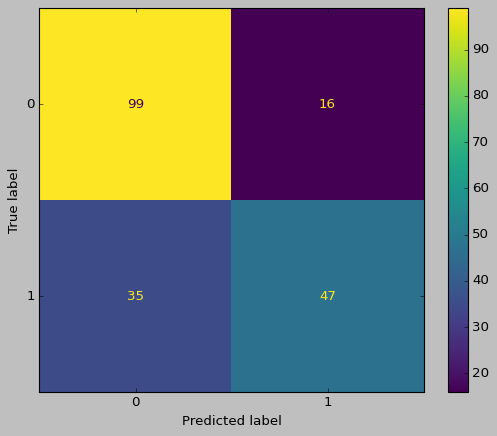

In [24]:
# display test accuracy
eclf_acc = accuracy_score(eclf_predict, y_test)
print("Test accuarcy: {:.2f}%".format(eclf_acc*100))

# plot confusion matrix
style.use('classic')
cm = confusion_matrix(y_test, eclf_predict, labels=eclf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=eclf.classes_)
disp.plot()

# display classification report table
report = classification_report(y_test, eclf_predict, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.head()


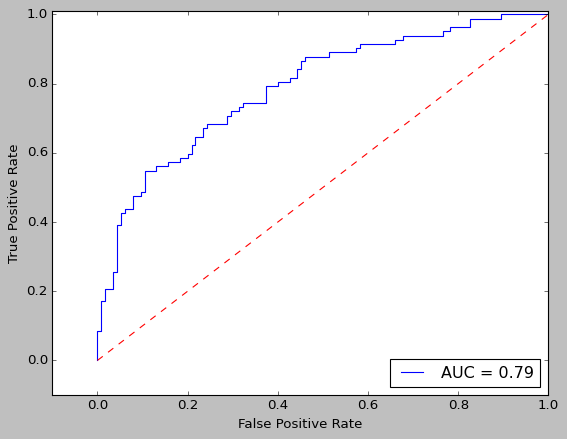

In [25]:
# calculating prediction probability
probas = [c.predict_proba(x_test) for c in eclf.estimators_]
avg_proba = np.average(probas, axis=0, weights=[0.33, 0.33, 0.34])
y_pred_proba = avg_proba[:,1]

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [26]:
# Save both the vectorizer and the model to disk
filename_voting_clf = 'voting_classifier.joblib'
filename_vectorizer = 'vectorizer.joblib'

joblib.dump(eclf, filename_voting_clf)
joblib.dump(vect, filename_vectorizer)

# saving the stop words list
with open("final_stop_words.txt", "w") as f:
    for word in final_stop_words:
        f.write(word + '\n')

## Main application

In [27]:
def preprocess_text(final_stop_words, text):
    
    # removal of capitalization
    text = text.lower()
    # remove numbers
    text = re.sub(r"\d+", "", str(text))
    # remove url
    text = re.sub(r"https?://\S+|www\.\S+", "", text)
    # remove HTML tags
    text = re.sub(r"<.*?>", "", text)
    # remove emojis
    text = emoji.replace_emoji(text, replace='')
    # remove re-tweets status
    text = re.sub(r'^RT @\w*: ', ' ', text)
    # remove mentions
    text = re.sub(r'@\w*', ' ', text)
    # remove special characters
    text = re.sub(r'[!@#&*$.?,]', ' ', text)
    # remove \n
    text = re.sub(r'\n', ' ', text)
    # remove ''
    text = re.sub("'", '', text)
    
    # tokenizing the text and removing stop words
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in final_stop_words]
    preprocessed_text = " ".join(filtered_text)
    
    return preprocessed_text

def extract_features(vectorizer, preprocessed_text):
    vectorized_text = vectorizer.transform([preprocessed_text])
    return vectorized_text

def classify_text(classifier_model, vectorizer, final_stop_words, text):
    
    # pre-process the text
    preprocessed_text = preprocess_text(final_stop_words, text)
    
    # Convert the text into numerical features
    text_features = extract_features(vectorizer, preprocessed_text)
    
    # Predict the depression status of the text
    pred_value = classifier_model.predict(text_features)
    
    # calculating prediction percentage
    probas = [c.predict_proba(text_features) for c in classifier_model.estimators_]
    avg_proba = np.average(probas, axis=0, weights=[0.33, 0.33, 0.34])
    percentage = np.max(avg_proba, axis = 1)
    
    return pred_value[0], percentage[0]

def display_results(prediction, percentage):
    if prediction == 1:
        print("The author of this text might be suffering from depression")
        print("Depression rate: {:.2f}%".format(percentage*100))
    else:
        print("The author of this text is not suffering from depression")
    

In [29]:
# loading the classifier and the vectorizer
loaded_voting_clf = joblib.load('voting_classifier.joblib')
loaded_vectorizer = joblib.load('vectorizer.joblib')

# loading the stopwords list
final_stop_words = []
with open("final_stop_words.txt", "r") as f:
    for line in f:
        final_stop_words.append(line.strip())
        
# Ask the user to input Singlish text
text = input("Enter the Singlish text: ")
        
# classifying the text and displaying the results
prediction, percentage = classify_text(loaded_voting_clf, loaded_vectorizer, final_stop_words, text)
display_results(prediction, percentage)

The author of this text might be suffering from depression
Depression rate: 82.50%
